# $GROUP$ $36$ $PROJECT$ $REPORT$
### $Predicting$ $Water$ $Levels$ $in$ $Venice$

**INTRODUCTION**

For our project, we are going to observe a dataset that describes water levels in Venice, Italy. Venice is known for its yearly flooding and is at risk of completely flooding in the future if water levels continue to rise. This dataset contains data from 1983 to 2015, and includes the water level in centimeters for every hour of every day. Our predictive question is:
### “What will the average water level in Venice be ten years from now?” 

Flooding in Venice is much more impactful and frequent than in other cities, as it is built on multiple small islands connected by bridges and water canals. Its location causes it to flood on a regular basis, but due to global warming and the nature of Venice’s geography, the floods have become increasingly severe over the years. For example, on November 12th 2019, residents of Venice went through the usual routine to prepare for a flood. The water level started to rise far above the predicted water level, destroying homes, business, and historical landmarks, and costing the city millions of dollars. A significant portion of Venice's economy relies on tourism and trade through its ports. Any significant flood would drive tourists away and slow down port activity, impacting the economy of the city on top of flood damage repairs. The floods in Venice are becoming more destructive and unpredictable, costing the city more and more each year, which is why we need to predict the water levels far into the future, so that the city can prepare for even higher floods. 

We aim to observe possible trends in the average water levels per year, starting from 1983, and use linear regression to predict how much the water level will increase in the future. Since the dataset ends at the year 2015, we want to predict the water level ten years from that, in 2025.


**DATA ANALYSIS**


In [5]:
library(tidyverse)
library(repr)
library(tidymodels)
library(tidyr)
options(repr.matrix.max.rows = 6)

We first loaded in our dataset and cleaned it by separating the `datetime` column into separate columns for year, month, and date. We used all the data from the original dataset, and did not need to remove any variables, as the dataset contains all the information we need already; the different water levels and the time at which they were recorded.

Next, we wrangled our data so that it contained the values we needed for our prediction. We filtered out the year 2016, as there was only 1 data point for it whereas the other years had thousands of data points. This prevents the data for 2016 from being an outlier. We then grouped our data by year and summarized it to take the mean of the water levels. This gives us an overall average water level for every year from 1983 to 2015. 

In [6]:
set.seed(2000) 

#read in dataset from web
data<-read_csv('https://github.com/lbcommer/venezia-high-waters/raw/master/output/venezia.csv') |>
                                separate(col=datetime, into=c('Year', 'Month', 'Date'), sep='-', convert=TRUE) |>
                                separate(col=Date, into=c('Day', 'Time'), sep=" ", convert=TRUE)

#filter the data and summarize it so it shows the monthly average of water levels in cm from 1983 to 2015
set.seed(2000)
filtered_data <- data |>  
filter(Year != "2016") |> group_by(Year,Month) |> summarise(month_average = mean(level))
filtered_data

water_ts <- ts(filtered_data, start=c(1983, 1), end = c(2015, 12), frequency=12) 

time_series_df <- as.data.frame(water_ts)

Rows: 289272 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): level
dttm (1): datetime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


Year,Month,month_average
<int>,<int>,<dbl>
1983,1,7.30148
1983,2,19.67262
1983,3,16.70430
⋮,⋮,⋮
2015,10,41.88038
2015,11,32.03889
2015,12,15.00941


**Explain first step** 

For spliting the data we chose a 70/30 split. We want to predict the yearly, monthly average for future years, therefore we split the data after wrangling so the testing and training data were both the same format.


In [7]:
set.seed(2000)

# add a sequence as a counter for the month starting from January 1983 and delete the year column
time_series_df<-mutate(time_series_df, tibble(Month=seq(1,396))) |>
select(-Year)
time_series_df

# use initial_time_split instead of initial_split since it's time series - not independent of each other
data_split <- initial_split(time_series_df, prop = 0.7, strata = Month)
training_data <- training(data_split)
testing_data <- testing(data_split)

training_data
testing_data

Month,month_average
<int>,<dbl>
1,7.30148
2,19.67262
3,16.70430
⋮,⋮
394,41.88038
395,32.03889
396,15.00941


,Month,month_average
,<int>,<dbl>
1,1,7.30148
2,2,19.67262
3,3,16.70430
⋮,⋮,⋮
392,392,34.35618
394,394,41.88038
396,396,15.00941


,Month,month_average
,<int>,<dbl>
4,4,26.35972
8,8,19.64382
9,9,21.39583
⋮,⋮,⋮
390,390,28.97083
393,393,38.80556
395,395,32.03889


**From inspection of the summary tibbles above, we can see that the `month_average` column, which represents the average water level for each month, is increasing as the years go by.**

Below is an initial plot of our training data. It shows the average water levels for every month of every year in our dataset, from January 1983 to December 2015. From the plot, we can observe that the average water levels fluctuate quite frequently between different months and years. However, there is an overall increasing trend as the years go by, indicating that on a broad level, water levels in Venice are rising as time passes.

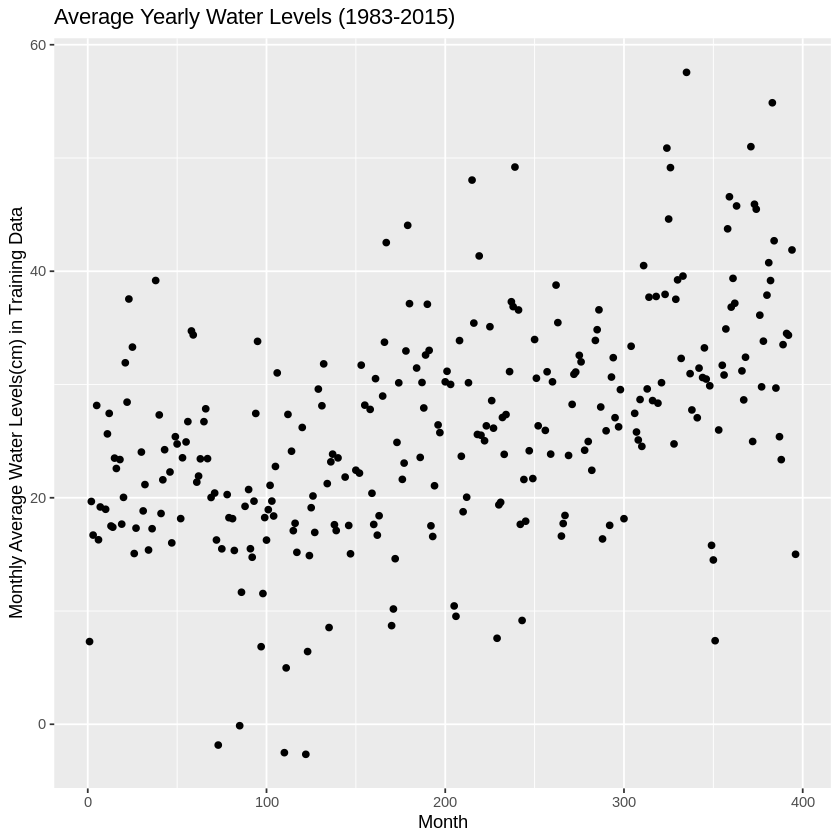

In [8]:
# visualize the training data of the monthly average water levels
graph_data <- training_data|>
ggplot(aes(x = Month, y = month_average)) + geom_point()+
labs( x = "Month", y = "Monthly Average Water Levels(cm) in Training Data", title = "Average Yearly Water Levels (1983-2015)")

graph_data

**Next, we created, trained, and fit our regression model. We chose to use linear regression to answer our predictive question because ... For our recipe, we used `Month` as our predictor variable. We want to predict `month_average`, which is the average water level.**

In [15]:
set.seed(2020)

# making the model for the prediction line
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")
data_recipe <- recipe(month_average ~ Month, data = training_data)

# fit our model into workflow
data_fit <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(lm_spec) |>
  fit(data = training_data)

data_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)        Month  
   17.67798      0.04213  


By inspection of the coefficients of our trained model above, we can see that there is a positive intercept and a positive value for `Month`. This indicates that the slope of our linear regression line is positive, which proves that as time passes, water levels are increasing.

We then evaluated the accuracy of our model by calculating the RMSE resulting from predicting on our training data, and then the RMSPE resulting from predicting on our testing data.

In [16]:
# calculating the root mean squared error (RMSE) of the model in training data
lm_rmse <- data_fit |>
  predict(training_data) |>
  bind_cols(training_data) |>
  metrics(truth = month_average, estimate = .pred) |>
  filter(.metric == "rmse") |>
   select(.estimate) |>
   pull()

lm_rmse

[1] 8.580688

In [17]:
# calculating the root mean squared predicted error (RMSPE) of the model in testing data
lm_rmspe <- data_fit |>
  predict(testing_data) |>
  bind_cols(testing_data) |>
  metrics(truth = month_average, estimate = .pred) |>
  filter(.metric == "rmse") |>
  select(.estimate) |>
  pull()

lm_rmspe

[1] 8.584946

Below is a visualization of our linear regression line plotted onto our data points. It is observed that the line has a positive slope, indicating the increase of water levels as time passes. As well, we have shown our model workflow again. Using the coefficients from the model, we can create an equation for the regression line that will allow us to predict the water level for future years.


`geom_smooth()` using formula 'y ~ x'



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)        Month  
   17.67798      0.04213  


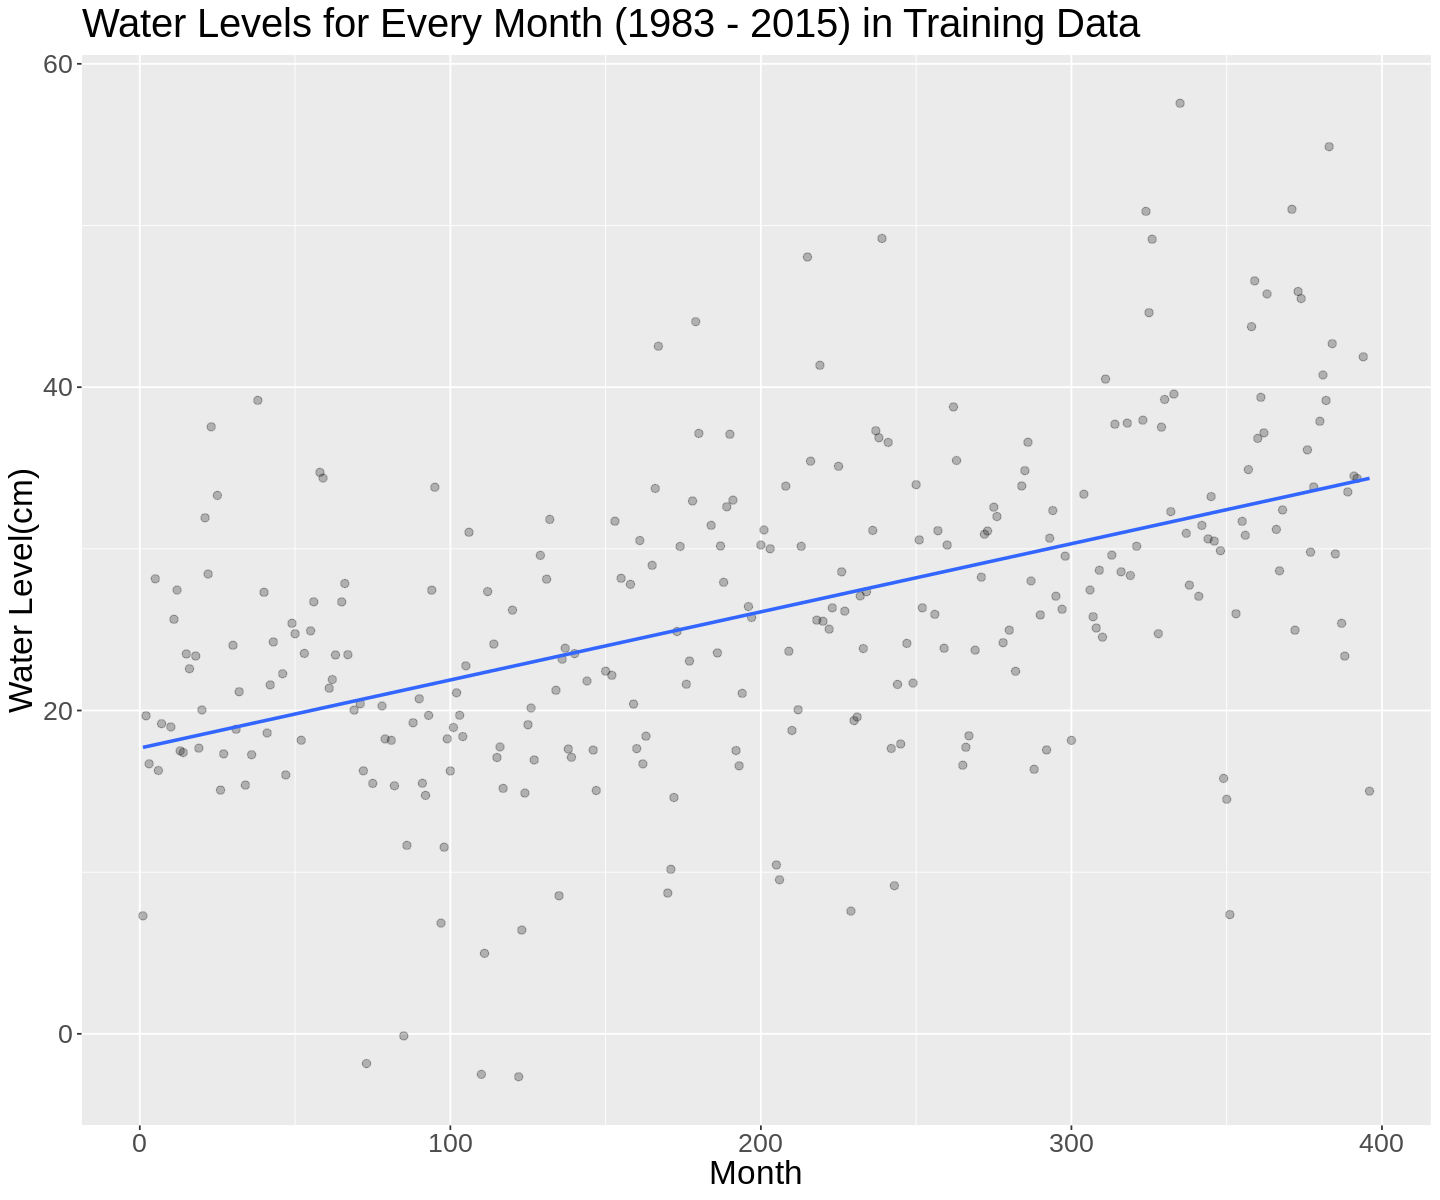

In [25]:
# plot the model in training data and show the model to get the intercept and slope of the prediction line
options(repr.plot.width = 12, repr.plot.height = 10)

lm_predictions_test <- training_data |>
     ggplot(aes(x = Month, y = month_average)) +
         geom_point(alpha = 0.25, size=2) +
         geom_smooth(data=training_data, aes(x = Month, y = month_average),method = "lm", se = FALSE) +
         xlab("Month") +
         ylab("Water Level(cm)") +
         ggtitle("Water Levels for Every Month (1983 - 2015) in Training Data") +
         theme(text = element_text(size = 20))

lm_predictions_test

data_fit

Based on the coefficients of our trained model, we can extract an equation for our regression line.

**EQUATION OF REGRESSION LINE:**

$water\: level = 17.67798 + 0.04213*month$

We can find the expected average water level for any month of any year by plugging the month's corresponding number into the equation.

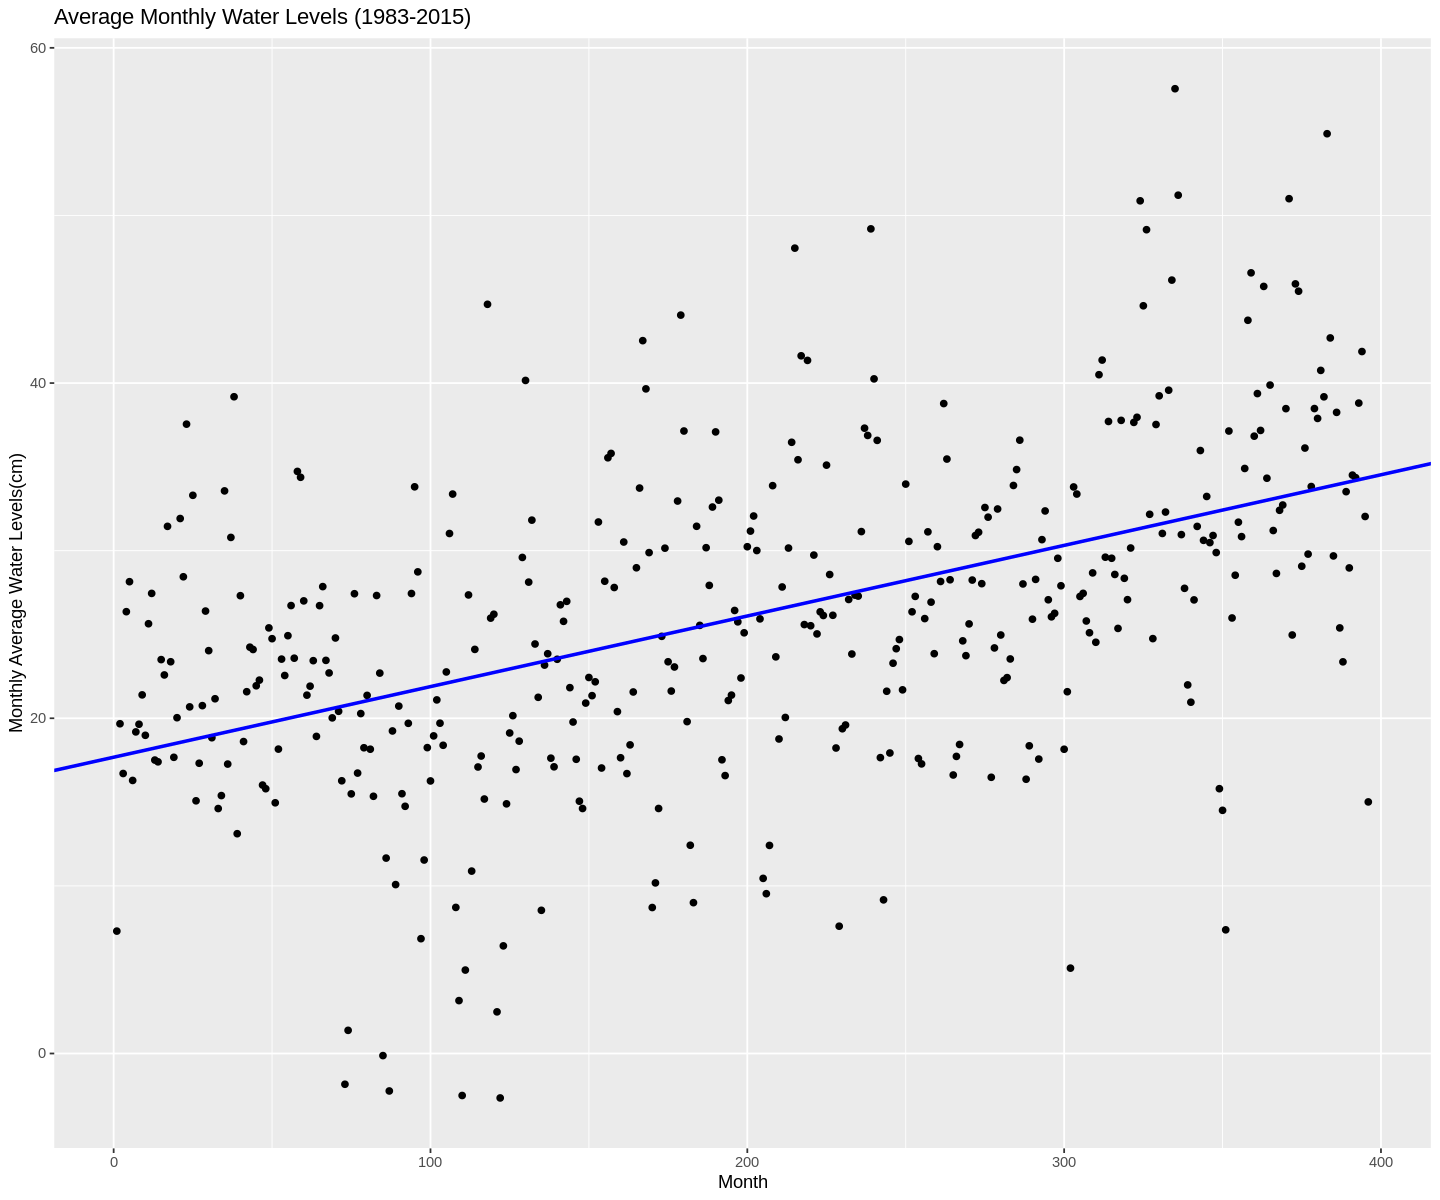

In [20]:
# plot the line using the intercept and slope we have on the original data
options(repr.plot.width = 12, repr.plot.height = 10)

prediction_line <- ggplot(time_series_df, aes(x = Month, y = month_average)) + 
    geom_point() +
    labs(x = "Month", y = "Monthly Average Water Levels(cm)", title = "Average Monthly Water Levels (1983-2015)") +
    geom_abline(intercept=17.67798, slope=0.04213, color='blue', lwd=1)

prediction_line

In the cell below, we used the equation of the regression line extracted above and plugged in different `Month` numbers to obtain the average water level for that month.

In [21]:
#in this cell we calculate all the predicted values for multiple years following 2015 using the slope formula obtained

#month 433 corresponds to january 2020
pred_1 <- 17.67798 + 433*0.04213
pred_1

#month 493 corresponds to january 2025
pred_2 <- 17.67798 + 493*0.04213
pred_2

#month 553 corresponds to january 2030
pred_3 <- 17.67798 + 553*0.04213
pred_3

#month 613 corresponds to january 2035
pred_4 <- 17.67798 + 613*0.04213
pred_4

#month 673 corresponds to january 2040
pred_5 <- 17.67798 + 673*0.04213
pred_5

#month 733 corresponds to january 2045
pred_6 <- 17.67798 + 733*0.04213
pred_6

#month 793 corresponds to january 2050
pred_7 <- 17.67798 + 793*0.04213
pred_7

[1] 35.92027

[1] 38.44807

[1] 40.97587

[1] 43.50367

[1] 46.03147

[1] 48.55927

[1] 51.08707

We converted this predicted water level data into a table to better understand and interpret it.

In [27]:
options(repr.matrix.max.rows = 8)

predicted_water_levels_until_2050 <- tibble(Year=c(2020, 2025, 2030, 2035, 2040, 2045, 2050),
                        'Predicted Water Level (cm)'=c(35.92027, 38.44807, 40.97587, 43.50367, 46.03147, 48.55927, 51.08707))
predicted_water_levels_until_2050         

Year,Predicted Water Level (cm)
<dbl>,<dbl>
2020,35.92027
2025,38.44807
2030,40.97587
2035,43.50367
2040,46.03147
2045,48.55927
2050,51.08707


**SUMMARY OF RESULTS**

**CITATIONS**


Kaggle link to original dataset: https://www.kaggle.com/datasets/lbronchal/venezia

Article about rising water levels in Venice posing danger of submersion for the city: https://thehill.com/changing-america/sustainability/climate-change/579490-an-expert-explains-how-rising-sea-levels-could/

Article about how climate change impacting water levels is affecting Venice's tourism economy: https://www.euronews.com/travel/2022/06/01/climate-change-and-cruise-ships-can-venice-survive-the-rising-tides

Article about destructive nature of floods in Venice, how people are affected: https://www.forbes.com/sites/rebeccahughes/2020/11/12/venice-1-year-on-from-devastating-flooding-no-more-acqua-alta/?sh=cc8eec14809f

Article about monetary cost and impact of flooding in Venice: https://www.businessinsider.com/flooding-cost-1-billion-of-damage-to-venice-tourist-attractions-2019-12

